In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device ='cuda'
batch_size =128
noise_dim=64
lr=.0002
beta_1=0.5
beta_2=.99
epochs=20


Load MNIST Dataset

In [4]:
from torchvision import datasets,transforms as T

In [5]:
train_augs=T.Compose([
    T.ToTensor(),
    T.RandomRotation((-20,+20)),
])

In [6]:
trainset=datasets.MNIST('MNIST/',download=True,train=True,transform=train_augs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 508kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.1MB/s]


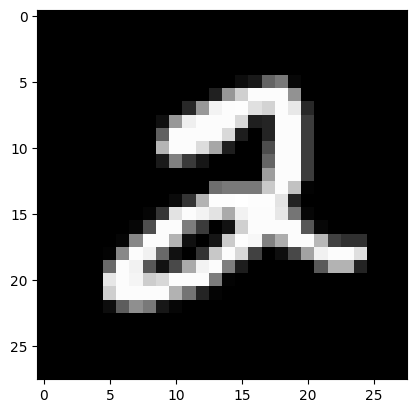

In [7]:
image, label = trainset[5]
plt.imshow(image.squeeze(), cmap='gray')

In [8]:
print("The total numbetr of trainset are: ",len(trainset))

The total numbetr of trainset are:  60000


Load dataset into batches

In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [11]:
Trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [12]:
print("Total number of train loadfer: ",len(Trainloader))

Total number of train loadfer:  469


In [17]:
dataiter=iter(Trainloader)
image, _ =next(dataiter)
print(image.shape)

torch.Size([128, 1, 28, 28])


In [18]:
def show_tensor_images(tensor_img,num_images=16,size=(1,28,28)):
    unflat_img=tensor_img.detach().cpu()
    img_grid=make_grid(unflat_img[:num_images],nrow=4)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.show()

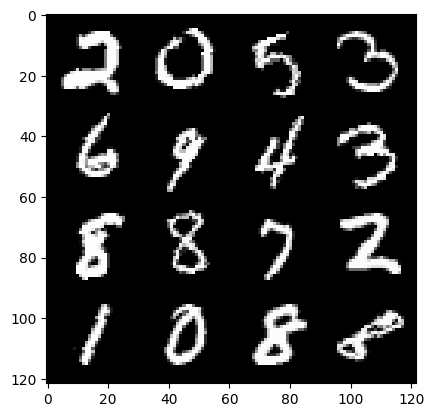

In [19]:
show_tensor_images(image,num_images=16)

Create Discriminator Network

In [20]:
from torch import nn
from torchsummary import summary

In [22]:
def get_disc_block(in_channels,out_channels,size,stride):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,size,stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [26]:
class Distriminator(nn.Module):
  def __init__(self):
    super().__init__() # Call the parent class constructor
    self.block_1=get_disc_block(1,16,(3,3),2)
    self.block_2=get_disc_block(16,32,(5,5),2)
    self.block_3=get_disc_block(32,64,(5,5),2)

    self.flatten=nn.Flatten()
    self.linear=nn.Linear(in_features=64,out_features=1)

  def forward(self,image): # forward method should be outside __init__ and use 'image'
     x1=self.block_1(image)
     x2=self.block_2(x1)
     x3=self.block_3(x2)

     x4=self.flatten(x3)
     x5=self.linear(x4)

     return x5

In [27]:
D=Distriminator()
D.to(device)
summary(D,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [28]:
def get_gen_block(in_channels,out_channels,size,stride,final_block=False):
  if final_block==True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,size,stride),
        nn.Tanh()
    )
  else:
        return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,size,stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [31]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()

    self.noise_dim=noise_dim

    self.block_1=get_gen_block(noise_dim,256,(3,3),2)
    self.block_2=get_gen_block(256,128,(4,4),1)
    self.block_3=get_gen_block(128,64,(3,3),2)

    self.block_4=get_gen_block(64,1,(4,4),2,final_block=True)

  def forward(self,r_noise_vec):
    x=r_noise_vec.view(-1,self.noise_dim,1,1 )

    x1=self.block_1(x)
    x2=self.block_2(x1)
    x3=self.block_3(x2)
    x4=self.block_4(x3)

    return x4

In [32]:
G=Generator(noise_dim)
G.to(device)
summary(G,input_size=(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [33]:
def weight_init(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
    nn.init.normal_(m.weight,0.0,0.02)

    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
      nn.init.normal_(m.weight,0.0,0.02)
      nn.init.constant_(m.bias,0.0)

In [34]:
D=D.apply(weight_init)
G=G.apply(weight_init)

Create loss function and loop optimizer

In [43]:
def real_lose(disc_pred):
  criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.ones_like(disc_pred)
  loss=criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(disc_pred)
  loss=criterion(disc_pred,ground_truth)
  return loss

In [39]:
D_opt=torch.optim.Adam(D.parameters(),lr=lr,betas=(beta_1,beta_2))
G_opt=torch.optim.Adam(G.parameters(),lr=lr,betas=(beta_1,beta_2))

Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.6421425477273937 | G_loss : 0.7634163505232918


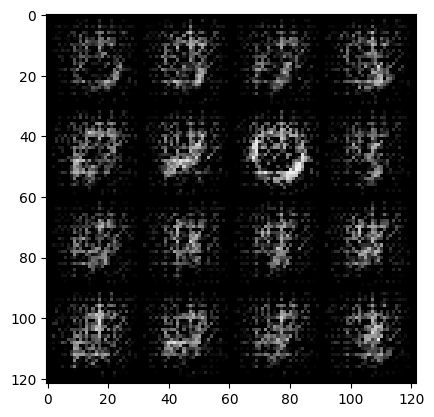

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.5927494545735276 | G_loss : 0.8370307350972059


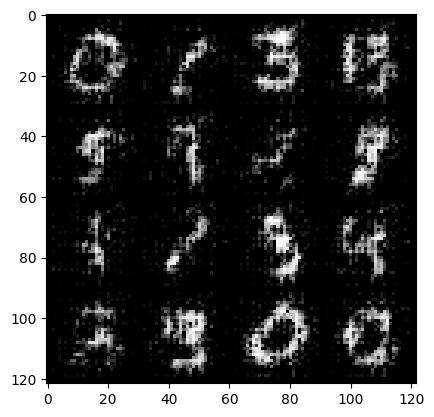

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.5690317578407239 | G_loss : 0.8860059017057358


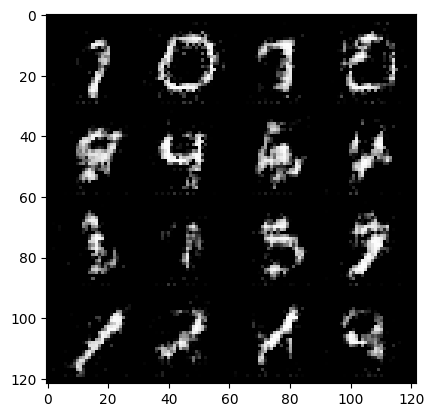

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.5605996667957509 | G_loss : 0.9146647816782059


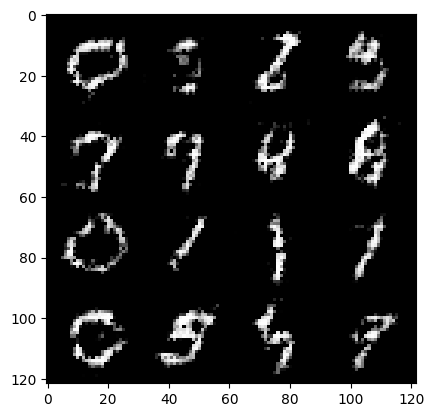

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.5533004988993663 | G_loss : 0.9407190967724521


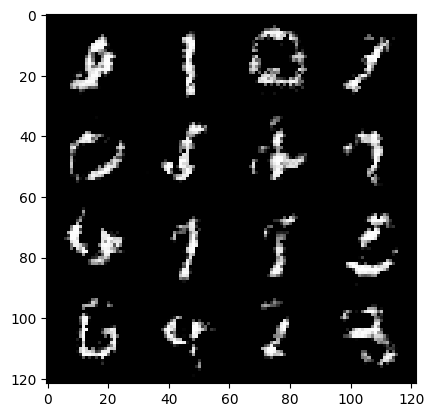

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.5479343523348826 | G_loss : 0.9644923318169518


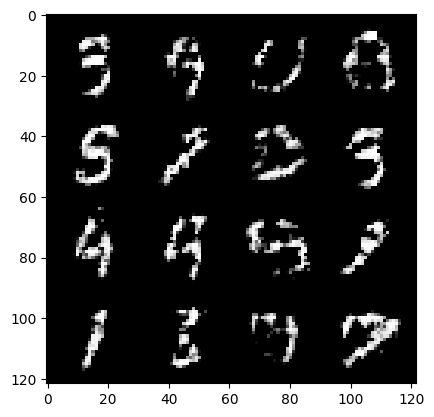

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.5496026552053911 | G_loss : 0.979344829440371


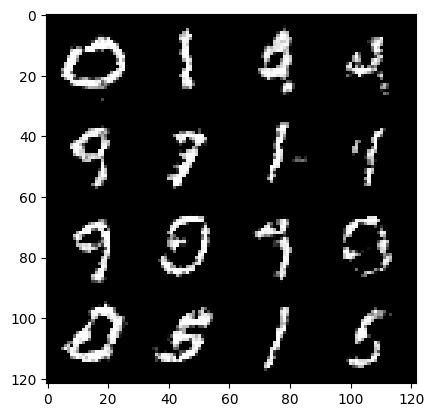

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.50227493969108 | G_loss : 1.0708467465982254


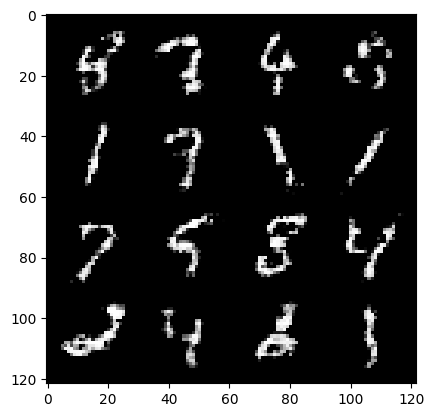

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.4839157001423175 | G_loss : 1.1374692892723246


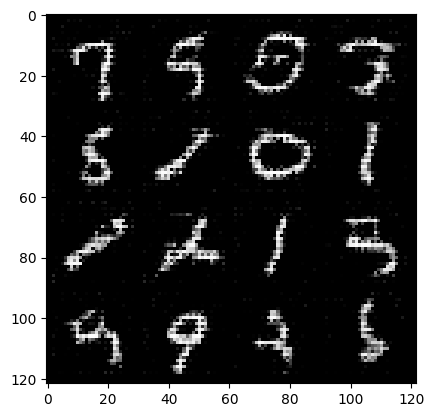

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
from tqdm.auto import tqdm

for i in range(epochs):
	total_d_loss=0
	total_g_loss=0

	for real_img,_ in tqdm(Trainloader):
		real_img=real_img.to(device)

		# Train Discriminator
		D_opt.zero_grad()

		# Loss for real images
		D_pred_real=D(real_img)
		D_real_loss=real_lose(D_pred_real)

		# Loss for fake images
		noise=torch.randn(batch_size,noise_dim,device=device)
		fake_img=G(noise)
		D_pred_fake=D(fake_img.detach()) # Detach to prevent G from updating
		D_fake_loss=fake_loss(D_pred_fake)

		D_loss=(D_real_loss+D_fake_loss)/2
		D_loss.backward()
		D_opt.step()

		total_d_loss+=D_loss.item()

		# Train Generator
		G_opt.zero_grad()

		noise=torch.randn(batch_size,noise_dim,device=device)
		fake_img=G(noise)
		D_pred_gen=D(fake_img)
		G_loss=real_lose(D_pred_gen) # Generator wants D to classify fakes as real

		total_g_loss+=G_loss.item()
		G_loss.backward()
		G_opt.step()

	avg_d_loss=total_d_loss/len(Trainloader)
	avg_g_loss=total_g_loss/len(Trainloader)

	print("Epoch : {} | D_loss : {} | G_loss : {}".format(i+1,avg_d_loss, avg_g_loss))

	show_tensor_images(fake_img)